# Linear Regression Base Case

In [7]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [8]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../')
from brain2brain import utils
from brain2brain import generators
%matplotlib inline
from sklearn.linear_model import LinearRegression

# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed

# Statsmodels
from statsmodels.tsa.arima_model import ARMA


In [1]:
def fit_lr(train_gen, val_gen):
    electrode_corr = np.empty(shape=(len(train_gen), train_gen[0][0].shape[2]))
    for batch_ix in range(len(train_gen)):
        print(f"Batch: {batch_ix}/{len(train_gen)}", end="\r")
        sample, targets = train_gen[batch_ix]
        for electrode in range(sample.shape[2]):
            print(f"Electrode {electrode}")
            X = sample[:, :, electrode]
            y = targets[:, :, electrode]
            model = LinearRegression().fit(X, y)
            final_r = eval_correlation(model, val_gen, electrode)
            print(f"final_r: {final_r}")
            electrode_corr[batch_ix, electrode] = final_r
        print(electrode_corr)
        return electrode_corr

def fit_lr_electrode(train_gen, val_gen, electrode):
    for batch_ix in range(len(train_gen)):
        print(f"Batch: {batch_ix}/{len(train_gen)}")
        sample, targets = train_gen[batch_ix]
        print(f"Electrode {electrode}")
        X = sample[:, :, electrode]
        y = targets[:, :, electrode]
        model = LinearRegression().fit(X, y)
        final_r = eval_correlation(model, val_gen, electrode, 0)
        print(f"final_r: {final_r}")
#         return electrode_corr
        return final_r
def fit_lr_electrode_batch_ix(train_gen, val_gen, electrode, batch_ix):
    print(f"Batch: {batch_ix}/{len(train_gen)}")
    sample, targets = train_gen[batch_ix]
    print(f"Electrode {electrode}")
    X = sample[:, :, electrode]
    y = targets[:, :, electrode]
    model = LinearRegression().fit(X, y)
    final_r = eval_correlation(model, val_gen, electrode, 0)
    print(f"final_r: {final_r}")
    return final_r

In [16]:
def eval_correlation(model, val_gen, electrode, batch_ix):
    sample, targets = val_gen[batch_ix]
    n_rows=sample.shape[0]
    r_array = np.empty(shape=(n_rows,))
    sample_maes = np.empty(shape=(n_rows,))
    for sample_ix in range(n_rows):
        X_test = sample[sample_ix, :, electrode]
        y_test = targets[sample_ix, :, electrode]
        predictions = np.empty(shape=(y_test.shape[0],))
        for prediction_row in range(y_test.shape[0]):
            X_1 = X_test[prediction_row:]
            X_2 = predictions[:prediction_row]
            X = np.concatenate((X_1, X_2))
            predict = model.predict([X])
            predict = predict.reshape(-1)
            predictions[prediction_row] = predict[0]
        # Calculate Correlation
        r, p_value = pearsonr(y_test, predictions)
        mae = np.mean(np.abs(predictions - y_test))
        sample_maes[sample_ix] = mae
        r_array[sample_ix] = r
    z_mean = np.mean(r_array)
    batch_r = np.tanh(z_mean)
    batch_mae = np.mean(sample_maes)
    print(f"Batch_r: {batch_r}")
    print(f"Batch Mae: {batch_mae}")
    return batch_r, batch_mae

In [23]:
def fit_lr_batch_ix(train_gen, val_gen, batch_ix):
    electrode_corr = np.empty(shape=(train_gen[0][0].shape[2],))
    electrode_mae = np.empty(shape=(train_gen[0][0].shape[2],))
    print(f"Batch: {batch_ix}/{len(train_gen)}")
    sample, targets = train_gen[batch_ix]
    for electrode in range(sample.shape[2]):
        X = sample[:, :, electrode]
        y = targets[:, :, electrode]
        model = LinearRegression().fit(X, y)
        final_r, mae_electrode = eval_correlation(model, val_gen, electrode, batch_ix)
        print(f"final_r for electrode {electrode} : {final_r}")
        print(f"mae for electrode {electrode} : {mae_electrode}")
        electrode_corr[electrode] = final_r
        electrode_mae[electrode] = mae_electrode
    print(electrode_corr)
    print(electrode_mae)
    return electrode_corr, electrode_mae


In [ ]:
def fit_lr_electrode(train_gen, val_gen, electrode, batch_ix):
    sample, targets = train_gen[batch_ix]
    X = sample[:, :, electrode]
    y = targets[:, :, electrode]
    model = LinearRegression().fit(X, y)
    final_r, mae_electrode = eval_correlation(model, val_gen, electrode, batch_ix)
    print(f"final_r for electrode {electrode} : {final_r}")
    print(f"mae for electrode {electrode} : {mae_electrode}")
    return final_r, mae_electrode


In [5]:
def fit_and_plot_lr_electrode(train_gen, val_gen, electrode, batch_ix, k):
    sample, targets = train_gen[batch_ix]
    X = sample[:, :, electrode]
    y = targets[:, :, electrode]
    model = LinearRegression().fit(X, y)
    final_r, mae_electrode = eval_and_plot_top_k_correlation(model, val_gen, electrode, batch_ix, k)
    print(f"final_r for electrode {electrode} : {final_r}")
    print(f"mae for electrode {electrode} : {mae_electrode}")
    return final_r, mae_electrode


# Binned Data

In [10]:
train_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
# Split the train files into a training and validation set.
electrode_count = 1
target_electrode = list(range(114))
# Training Generator
train_bin_norm_generator = generators.FGenerator(file_paths=train_bin_norm_paths,
                                        lookback=50,
                                        length=10,
                                        delay=0,
                                        batch_size=20000,
                                        sample_period=1,
                                        electrodes=target_electrode,
                                        shuffle=True)
# Validation Generator
val_bin_norm_generator = generators.FGenerator(file_paths=val_bin_norm_paths,
                                        lookback=50,
                                        length=10,
                                        delay=0,
                                        batch_size=5000,
                                        sample_period=1,
                                        electrodes=target_electrode,
                                        shuffle=False)

In [11]:
len(train_bin_norm_generator)

1

In [12]:
len(val_bin_norm_generator)

1

In [32]:
bin_norm_ele_corr, bin_norm_ele_mae = fit_lr_batch_ix(train_bin_norm_generator,
                                                      val_bin_norm_generator, 0)

Batch: 0/5
Batch_r: 0.08305808456736359
Batch Mae: 0.6501954474793163
final_r for electrode 0 : 0.08305808456736359
mae for electrode 0 : 0.6501954474793163
Batch_r: 0.09069256761373536
Batch Mae: 0.6335234506273333
final_r for electrode 1 : 0.09069256761373536
mae for electrode 1 : 0.6335234506273333
Batch_r: 0.09013676591018079
Batch Mae: 0.6248538936725658
final_r for electrode 2 : 0.09013676591018079
mae for electrode 2 : 0.6248538936725658
Batch_r: 0.06723879835209687
Batch Mae: 0.6427427460559417
final_r for electrode 3 : 0.06723879835209687
mae for electrode 3 : 0.6427427460559417
Batch_r: 0.05950375560198597
Batch Mae: 0.6326119291100679
final_r for electrode 4 : 0.05950375560198597
mae for electrode 4 : 0.6326119291100679
Batch_r: 0.08449272023131207
Batch Mae: 0.5701914196735459
final_r for electrode 5 : 0.08449272023131207
mae for electrode 5 : 0.5701914196735459
Batch_r: 0.05439817366228996
Batch Mae: 0.624637595445099
final_r for electrode 6 : 0.05439817366228996
mae for e

In [46]:
bin_norm_ele_corr

array([0.08305808, 0.09069257, 0.09013677, 0.0672388 , 0.05950376,
       0.08449272, 0.05439817, 0.06930719, 0.09969084, 0.07623172,
       0.06311364, 0.05962509, 0.05239973, 0.06740081, 0.06793045,
       0.06375254, 0.0753129 , 0.08278731, 0.05703196, 0.05645318,
       0.05608635, 0.05450263, 0.06160345, 0.07611993, 0.06015963,
       0.06188808, 0.06066647, 0.0563014 , 0.05780186, 0.07905842,
       0.07458691, 0.08827247, 0.1277474 , 0.12937967, 0.07260382,
       0.09969625, 0.07987552, 0.08281637, 0.07573662, 0.0620911 ,
       0.13471892, 0.0772998 , 0.06736324, 0.06498741, 0.09506057,
       0.07944214, 0.07121312, 0.09059099, 0.13133136, 0.06697542,
       0.06434849, 0.059147  , 0.0655475 , 0.06608393, 0.0726358 ,
       0.09868494, 0.14605863, 0.06335519, 0.06627146, 0.06311407,
       0.08405945, 0.08610728, 0.0726796 , 0.07976638, 0.10466725,
       0.10323357, 0.1021227 , 0.07317533, 0.09576389, 0.12410749,
       0.0994147 , 0.07850435, 0.07829651, 0.05533033, 0.07041

In [56]:
def get_top_k_electrodes(arr, k, metric):
    top_k_ix = np.empty(shape=(k,), dtype=int)
    top_k = np.empty(shape=(k,))
    if metric == "r":
        result = np.argsort(np.abs(arr))[:k]
    elif metric == "mae":
        result = np.argsort(arr)[:k]
    else:
        raise Exception("Metric does not exist.")
    for i in range(k):
        value = arr[result[i]]
        print(f"Electrode {result[i]}, {metric}={value}")
        top_k[i] = value
        top_k_ix[i] = result[i]
    return top_k_ix, top_k

In [105]:
mae_ix, result_mae = get_top_k_electrodes(bin_norm_ele_mae, 15, "mae")

Electrode 5, mae=0.5701914196735459
Electrode 7, mae=0.5789794604139008
Electrode 103, mae=0.5832328853175225
Electrode 107, mae=0.5936962172263719
Electrode 15, mae=0.5947808158438369
Electrode 94, mae=0.6014160249000917
Electrode 25, mae=0.6033140265505627
Electrode 20, mae=0.6034125036886496
Electrode 108, mae=0.6055219143500679
Electrode 14, mae=0.6063354798519205
Electrode 99, mae=0.6085106189103839
Electrode 105, mae=0.6134717698593954
Electrode 21, mae=0.6145331410834322
Electrode 93, mae=0.6168968641480941
Electrode 13, mae=0.6175689946423865


In [106]:
r_ix, result_r = get_top_k_electrodes(bin_norm_ele_corr, 15, "r")

Electrode 93, r=0.043445313919496784
Electrode 113, r=0.05092994396674768
Electrode 100, r=0.05095894165699574
Electrode 12, r=0.05239972550778003
Electrode 88, r=0.0538477308192269
Electrode 6, r=0.05439817366228996
Electrode 21, r=0.05450262945216036
Electrode 98, r=0.05461536305610901
Electrode 73, r=0.0553303296204973
Electrode 99, r=0.05569725031620954
Electrode 20, r=0.05608635058635371
Electrode 27, r=0.05630140092378782
Electrode 105, r=0.056322096782059905
Electrode 19, r=0.056453181815395104
Electrode 18, r=0.05703196424787678


In [107]:
np.intersect1d(mae_ix, r_ix)

array([ 20.,  21.,  93.,  99., 105.])

In [108]:
# Electrode 5
print(f"electrode 5 mae: {bin_norm_ele_mae[5]}")
print(f"electrode 5 corr: {bin_norm_ele_corr[5]}")

electrode 5 mae: 0.5701914196735459
electrode 5 corr: 0.08449272023131207


# Plot The Best Sample For Electrode 5

In [64]:
def eval_and_plot_top_k_correlation(model, val_gen, electrode, batch_ix, k):
    samples, targets = val_gen[batch_ix]
    n_rows=samples.shape[0]
    pred_length = targets[0, :, electrode].shape[0]
    r_array = np.empty(shape=(n_rows,))
    sample_maes = np.empty(shape=(n_rows,))
    sample_predictions = np.empty(shape=(n_rows, pred_length))
    for sample_ix in range(n_rows):
        X_test = samples[sample_ix, :, electrode]
        y_test = targets[sample_ix, :, electrode]
        predictions = np.empty(shape=(pred_length,))
        for prediction_row in range(pred_length):
            X_1 = X_test[prediction_row:]
            X_2 = predictions[:prediction_row]
            X = np.concatenate((X_1, X_2))
            predict = model.predict([X])
            predict = predict.reshape(-1)
            predictions[prediction_row] = predict[0]
        # Calculate Correlation
        sample_predictions[sample_ix] = predictions
        r, p_value = pearsonr(y_test, predictions)
        mae = np.mean(np.abs(predictions - y_test))
        sample_maes[sample_ix] = mae
        r_array[sample_ix] = r
    z_mean = np.mean(r_array)
    batch_r = np.tanh(z_mean)
    batch_mae = np.mean(sample_maes)
    top_k_ix, top_k_val = get_top_k_electrodes(sample_maes, 5, "mae")
    for i in range(k):
        sample_ix = top_k_ix[i]
        target = targets[sample_ix, :, electrode]
        prediction = sample_predictions[top_k_ix[i]]
        sample = samples[sample_ix, :, electrode]
        print(f"Sample {top_k_ix[i]}, mae:{top_k_val[i]}, r:{pearsonr(target, prediction)}")
        plt.figure(figsize=(10,6))   
        x_sample = sample.shape[0]
        print(target.shape)
        print(sample.shape)
        sample=np.concatenate([sample, target[:1]])
        plt.plot(range(0,x_sample+1), sample)
        plt.plot(range(x_sample,x_sample+len(target)), target, color='orange')
        plt.plot(range(x_sample,x_sample+len(target)), prediction, color='teal', linestyle='--')
        plt.title(f'Linear Regression Test, 500ms, Patient 676, Electrode {electrode}, Sample {top_k_ix[i]}')
        plt.legend(['Sample Series','Target Series','Predictions'])
    print(f"Batch_r: {batch_r}")
    print(f"Batch Mae: {batch_mae}")
    return batch_r, batch_mae

Electrode 1829, mae=0.1385537801149269
Electrode 1283, mae=0.14315808695220783
Electrode 238, mae=0.15107921734470692
Electrode 955, mae=0.15236053828187265
Electrode 4119, mae=0.16634776296993567
Sample 1829, mae:0.1385537801149269, r:(0.2751623949319404, 0.4416230358200116)
(10,)
(50,)
Sample 1283, mae:0.14315808695220783, r:(0.40172564082459306, 0.24984015506498394)
(10,)
(50,)
Sample 238, mae:0.15107921734470692, r:(-0.1611594874246497, 0.656478027413331)
(10,)
(50,)
Sample 955, mae:0.15236053828187265, r:(0.2759489229557329, 0.4402654242568163)
(10,)
(50,)
Sample 4119, mae:0.16634776296993567, r:(-0.2440719018120087, 0.49677746860341754)
(10,)
(50,)
Batch_r: 0.09393498755843299
Batch Mae: 0.5681743560526238
final_r for electrode 5 : 0.09393498755843299
mae for electrode 5 : 0.5681743560526238


(0.09393498755843299, 0.5681743560526238)

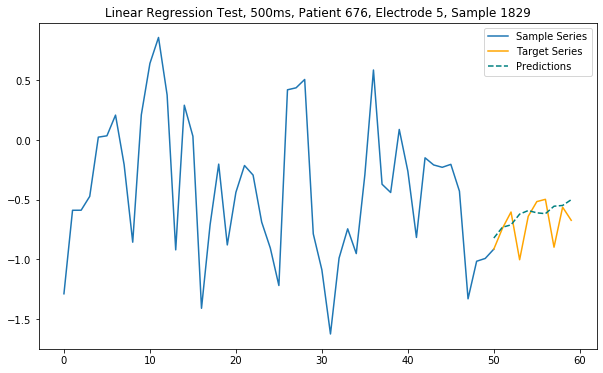

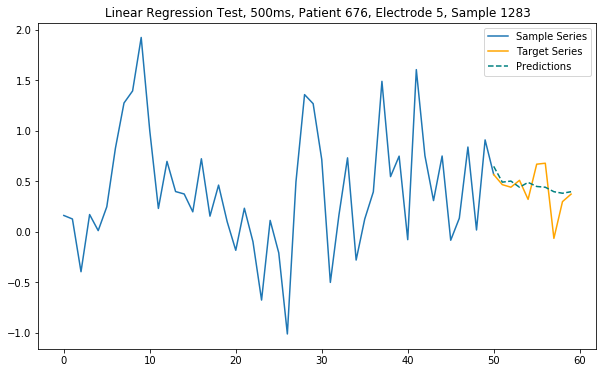

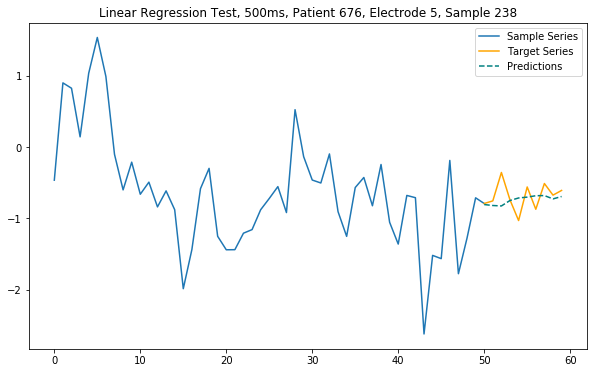

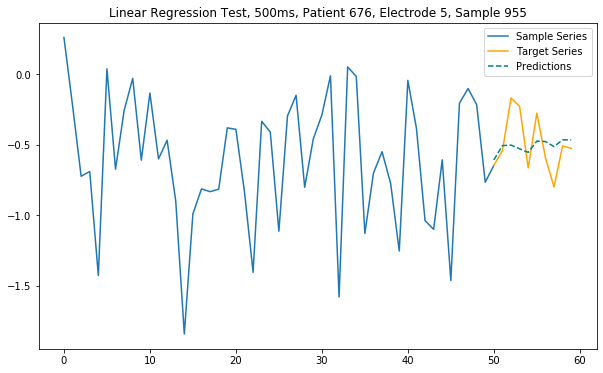

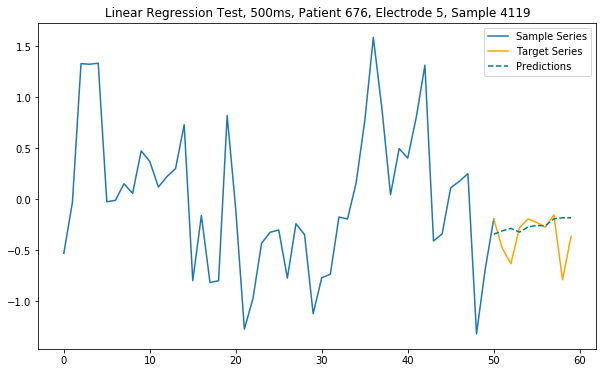

In [65]:
# Train Electrode 5 (And 5 only) again
# Save top 5 evaluation (by mae/corr)
fit_and_plot_lr_electrode(train_bin_norm_generator, val_bin_norm_generator, 5, 0, 5)

# Normalized Data

In [3]:
train_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_norm_2.txt")
val_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_norm_2.txt")
# Split the train files into a training and validation set.
electrode_count = 1
target_electrode = list(range(114))
# Training Generator65536 * 2
train_generator = generators.FGenerator(file_paths=train_paths,
                                        lookback=128,
                                        length=1,
                                        delay=0,
                                        batch_size=20000,
                                        sample_period=1,
                                        electrodes=target_electrode,
                                        shuffle=True,
                                        ratio=0.5)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_paths,
                                        lookback=128,
                                        length=25,
                                        delay=0,
                                        batch_size=5000,
                                        sample_period=1,
                                        electrodes=target_electrode,
                                        shuffle=False,
                                        ratio=0.5)

In [4]:
len(train_generator)

8

In [5]:
len(val_generator)

7

In [188]:
test_batch = val_generator[14]

In [8]:
a = np.array([1, 2, 3, 4])
b = np.array([2, 3, 4, 5])
a1 = np.array([1, 2, 3, 4])
b1 = np.array([2, 3, 3, 4])
c = a-b
c1 = a1-b1
np.mean(np.abs(c))

1.0

In [10]:
def fit_lr(train_gen, val_gen):
    electrode_corr = np.empty(shape=(len(train_gen), train_gen[0][0].shape[2]))
    for batch_ix in range(len(train_gen)):
        print(f"Batch: {batch_ix}/{len(train_gen)}", end="\r")
        sample, targets = train_gen[batch_ix]
        for electrode in range(sample.shape[2]):
            print(f"Electrode {electrode}")
            X = sample[:, :, electrode]
            y = targets[:, :, electrode]
            model = LinearRegression().fit(X, y)
            final_r = eval_correlation(model, val_gen, electrode)
            print(f"final_r: {final_r}")
            electrode_corr[batch_ix, electrode] = final_r
        print(electrode_corr)
        return electrode_corr

def fit_lr_electrode(train_gen, val_gen, electrode):
    for batch_ix in range(len(train_gen)):
        print(f"Batch: {batch_ix}/{len(train_gen)}")
        sample, targets = train_gen[batch_ix]
        print(f"Electrode {electrode}")
        X = sample[:, :, electrode]
        y = targets[:, :, electrode]
        model = LinearRegression().fit(X, y)
        final_r = eval_correlation(model, val_gen, electrode, 0)
        print(f"final_r: {final_r}")
#         return electrode_corr
        return final_r
def fit_lr_electrode_batch_ix(train_gen, val_gen, electrode, batch_ix):
    print(f"Batch: {batch_ix}/{len(train_gen)}")
    sample, targets = train_gen[batch_ix]
    print(f"Electrode {electrode}")
    X = sample[:, :, electrode]
    y = targets[:, :, electrode]
    model = LinearRegression().fit(X, y)
    final_r = eval_correlation(model, val_gen, electrode, 0)
    print(f"final_r: {final_r}")
    return final_r

In [17]:
def eval_correlation(model, val_gen, electrode, batch_ix):
    sample, targets = val_gen[batch_ix]
    r_array = np.empty(shape=(sample.shape[0],))
    sample_maes = np.empty(shape=(sample.shape[0],))
    for sample_ix in range(sample.shape[0]):
        X_test = sample[sample_ix, :, electrode]
        y_test = targets[sample_ix, :, electrode]
        predictions = np.empty(shape=(y_test.shape[0],))
        for prediction_row in range(y_test.shape[0]):
            X_1 = X_test[prediction_row:]
            X_2 = predictions[:prediction_row]
            X = np.concatenate((X_1, X_2))
            predict = model.predict([X])
            predictions[prediction_row] = predict
        # Calculate Correlation
        r, p_value = pearsonr(y_test, predictions)
        mae = np.mean(np.abs(predictions - y_test))
        sample_maes[sample_ix] = mae
        r_array[sample_ix] = r
    z_mean = np.mean(r_array)
    batch_r = np.tanh(z_mean)
    batch_mae = np.mean(sample_maes)
    print(f"Batch_r: {batch_r}")
    print(f"Batch Mae: {batch_mae}")
    return batch_r, batch_mae

In [18]:
def fit_lr_batch_ix(train_gen, val_gen, batch_ix):
    electrode_corr = np.empty(shape=(train_gen[0][0].shape[2],))
    electrode_mae = np.empty(shape=(train_gen[0][0].shape[2],))
    print(f"Batch: {batch_ix}/{len(train_gen)}")
    sample, targets = train_gen[batch_ix]
    for electrode in range(sample.shape[2]):
        X = sample[:, :, electrode]
        y = targets[:, :, electrode]
        model = LinearRegression().fit(X, y)
        final_r, mae_electrode = eval_correlation(model, val_gen, electrode, batch_ix)
        print(f"final_r for electrode {electrode} : {final_r}")
        print(f"mae for electrode {electrode} : {mae_electrode}")
        electrode_corr[electrode] = final_r
        electrode_mae[electrode] = mae_electrode
    print(electrode_corr)
    print(electrode_mae)
    return electrode_corr, electrode_mae

In [19]:
norm_ele_corr, norm_ele_mae = fit_lr_batch_ix(train_generator, val_generator, 0)

Batch: 0/8
Batch_r: 0.6981074542764151
Batch Mae: 0.10797154125587874
final_r for electrode 0 : 0.6981074542764151
mae for electrode 0 : 0.10797154125587874
Batch_r: 0.6959019875699702
Batch Mae: 0.10698735540789478
final_r for electrode 1 : 0.6959019875699702
mae for electrode 1 : 0.10698735540789478
Batch_r: 0.6956048591744605
Batch Mae: 0.10617855445315681
final_r for electrode 2 : 0.6956048591744605
mae for electrode 2 : 0.10617855445315681
Batch_r: 0.6969608061330654
Batch Mae: 0.10824536563333068
final_r for electrode 3 : 0.6969608061330654
mae for electrode 3 : 0.10824536563333068
Batch_r: 0.696733457872414
Batch Mae: 0.11010572169177779
final_r for electrode 4 : 0.696733457872414
mae for electrode 4 : 0.11010572169177779
Batch_r: 0.6951877741856269
Batch Mae: 0.08700151278106039
final_r for electrode 5 : 0.6951877741856269
mae for electrode 5 : 0.08700151278106039
Batch_r: 0.6980898934084407
Batch Mae: 0.11312792271618509
final_r for electrode 6 : 0.6980898934084407
mae for ele